In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
import cv2
import scipy.misc
from PIL import Image
from IPython.core.ultratb import AutoFormattedTB
from sklearn.metrics import confusion_matrix

__ITB__ = AutoFormattedTB(mode = 'Plain',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
def get_raw_accuracy(y_hat, y_truth):
    # print('y_hat', y_hat.shape)
    # print('y_truth', y_truth.shape)
    # Acc
    correct = 0
    for pred, target in zip(y_hat, y_truth):
        # print('target', target.item())
        pred = torch.argmax(pred, dim=0).long()
        # print('pred', pred.item())
        correct += 1 if pred.item() is target.item() else 0
        # print('correct', correct)
        
    acc = correct/len(y_truth)
    # print('accuracy',acc)
    return acc

In [0]:
# Resnet model
# Note: No batch normalization, weight regularization, or weight initialization used
class Block(nn.Module):
    # todo: make activation swappable
    # todo: make batchnorm togglable (also what is batchnorm)
    # todo: regularization
    # todo: weight initialization?
    def __init__(self, in_channels, out_channels, downsample=None, final=False):
        super(Block, self).__init__()
        self.activation = nn.ReLU()
        self.downsample = downsample

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1 if not downsample else 2, padding = 1),
            self.activation,
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
        )
        
    # official network takes in input, and adds the input to its own output, THEN ReLU then output
    def forward(self, input):
        # print('\ninput',input.shape)
        identity = input
        # pass input through block
        out = self.net(input)
        # print('out',out.shape)

        # skip connection
        if self.downsample is not None:
            identity = self.downsample(identity)
        # print('identity', identity.shape)
        out += identity
        output = self.activation(out)

        return output

class ResNet(nn.Module):
    # this method is always for instantiating the layers of the network
    def __init__(self):
        super(ResNet, self).__init__()
        self.dwnsmple1 = nn.Conv2d(3,32,1,stride=1)
        self.dwnsmple2 = nn.Conv2d(32,64,3,stride=2,padding=1)
        self.dwnsmple3 = nn.Conv2d(64,128,3,stride=2,padding=1)
        self.dwnsmple4 = nn.Conv2d(128,256,3,stride=2,padding=1)
        self.dwnsmple5 = nn.Conv2d(256,512,3,stride=2,padding=1)
        self.penultimate = nn.Conv2d(512,10,3,stride=2,padding=1) 

        self.block1 = Block(32,32) 
        self.block2 = Block(32,64,downsample=self.dwnsmple2) # halve image size
        self.block3 = Block(64,64)
        self.block4 = Block(64,64)
        self.block5 = Block(64,64) 
        self.block6 = Block(64,128,downsample=self.dwnsmple3) # halve image size
        self.block7 = Block(128,128)
        self.block8 = Block(128,128)
        self.block9 = Block(128,128)
        self.block10 = Block(128,256,downsample=self.dwnsmple4) # halve img size
        self.block11 = Block(256,256)
        self.block12 = Block(256,256)
        self.block13 = Block(256,256)
        self.block14 = Block(256,256)
        self.block15 = Block(256,256)
        self.block16 = Block(256,512,downsample=self.dwnsmple5) # halve img size
        self.block17 = Block(512,512)
        self.block18 = Block(512,512)
        self.block19 = Block(512,512)
        self.block20 = Block(512,512)

        # not used
        self.avg_pool = nn.AvgPool2d(2)
    
    def forward(self, input):
        input = input.cuda()
        input_resized = self.dwnsmple1(input) # Resize channels w/out changing image size (I understand this is technically cheating but o-well)
        o1 = self.block1(input_resized)
        o2 = self.block2(o1)
        o3 = self.block3(o2)
        o4 = self.block4(o3)
        o5 = self.block5(o4)
        o6 = self.block6(o5)
        o7 = self.block7(o6)
        o8 = self.block8(o7)
        o9 = self.block9(o8)
        o10 = self.block10(o9)
        o11 = self.block11(o10)
        o12 = self.block12(o11)
        o13 = self.block13(o12)
        o14 = self.block14(o13)
        o15 = self.block15(o14)
        o16 = self.block16(o15)
        o17 = self.block17(o16)
        o18 = self.block18(o17)
        o19 = self.block19(o18)
        o20 = self.block20(o19)

        out = self.penultimate(o20)


        # print('o1', o1.shape)
        # print('o2', o2.shape)
        # print('o3', o3.shape)
        # print('o4', o4.shape)
        # print('o5', o5.shape)
        # print('o6', o6.shape)
        # print('o7', o7.shape)
        # print('o8', o8.shape)
        # print('o9', o9.shape)
        # print('o10', o10.shape)
        # print('o11', o11.shape)
        # print('o12', o12.shape)
        # print('o13', o13.shape)
        # print('o14', o14.shape)
        # print('o15', o15.shape)
        # print('o16', o16.shape)
        # print('o17', o17.shape)
        # print('o18', o18.shape)
        # print('o19', o19.shape)
        # print('o20', o20.shape)
        # print('out', out.shape)

        return out.squeeze(2).squeeze(2)


In [0]:
# Parameter count function

In [0]:
# TRAINING SETUP
# Init datasets
trans = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])
train_set = torchvision.datasets.CIFAR10('.', True, transform=trans, download=True)
test_set = torchvision.datasets.CIFAR10('.', False, transform=trans, download=True)
# Init Dataloaders
train_loader = DataLoader(train_set, batch_size=200, num_workers=20, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=200, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Init model

model = ResNet()
model.cuda()
# Init optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Init loss function
objective = nn.CrossEntropyLoss()

In [0]:
train_losses = []
val_losses = []

In [0]:
validation_accs = []
accuracies = []

In [0]:
# TRAINING LOOP
n_epochs = 20
for epoch in range(n_epochs):
    loop = tqdm(total=len(train_loader), position=0, leave=False)
    for batch, (x,y_truth) in enumerate(train_loader):
        # print(y_truth)
        # print('\ny_truth.shape:',y_truth.shape)
        # 1. Zero grad
        optimizer.zero_grad()
        # 2. Put x, y_truth onto GPU
        x = x.cuda()
        y_truth = y_truth.cuda()
        # 3. Compute prediction (get y_hat)
        y_hat = model(x)
        # print('\ny_hat.shape:',y_hat.shape)
        # 4. Compute loss
        loss = objective(y_hat, y_truth)
        # 5. Compute gradient and step
        loss.backward()
        optimizer.step()

        # Housekeeping
        train_losses.append(loss)
        accuracy = get_raw_accuracy(y_hat, y_truth)
        mem = torch.cuda.memory_allocated(0) / 1e9
        accuracies.append(accuracy)
        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch, loss, accuracy, mem))
        loop.update(1)

    # Validation Loop (cute and optimized)
    # compute the loss for all x, y in val_loader, then get the mean of those losses
    val = np.mean([objective(model(x.cuda()), y.cuda().long()).item()
                    for x, y in test_loader
                    ])
    val_losses.append((len(train_losses), val))
    val_acc = np.mean([get_raw_accuracy(model(x.cuda()), y.cuda().long())
                    for x, y in test_loader
                    ])
    validation_accs.append((len(accuracies), val_acc))
    print('\nVal Loss: {:.4f}, Val Accuracy: {:.3f}'.format(val, val_acc))

    loop.close()

    


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.6366, Val Accuracy: 0.387


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.4849, Val Accuracy: 0.454


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.3401, Val Accuracy: 0.521


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.2426, Val Accuracy: 0.557


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.1472, Val Accuracy: 0.590


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.0883, Val Accuracy: 0.609


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.1750, Val Accuracy: 0.601


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.0933, Val Accuracy: 0.632


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.1010, Val Accuracy: 0.619


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.0713, Val Accuracy: 0.627


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.0736, Val Accuracy: 0.641


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.1355, Val Accuracy: 0.637


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.1132, Val Accuracy: 0.648


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.1886, Val Accuracy: 0.628


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.2266, Val Accuracy: 0.660


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.4749, Val Accuracy: 0.643


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.4232, Val Accuracy: 0.644


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.4721, Val Accuracy: 0.653


  0%|          | 0/250 [00:00<?, ?it/s]


Val Loss: 1.5185, Val Accuracy: 0.654



Val Loss: 1.6252, Val Accuracy: 0.661


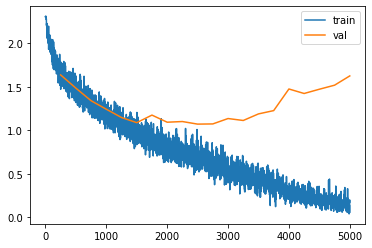

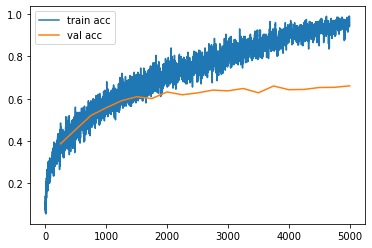

In [0]:
# Show loss curve
# validations is a list of tuples, this unzips it into two lists
a, b = zip(*val_losses)
plt.plot(train_losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()

# Show accuracy progression
a1, b1 = zip(*validation_accs)
plt.plot(accuracies, label='train acc')
plt.plot(a1, b1, label='val acc')
plt.legend()
plt.show()

In [0]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Save model (to drive)
model_save_name = 'basic_classifier_20.pt'
path = "/content/drive/My Drive/Colab Notebooks/CS 674/{}".format(model_save_name) 
torch.save(model.state_dict(), path)

In [0]:
# Number of parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Trainable Parameters:', num_trainable_params)

Number of Trainable Parameters: 32220810


In [0]:
# Create confusion matrix
# loop over validation set
confusion = torch.zeros(10,10)
for x, y_truth in test_loader:
    preds = model(x)

    for i, pred in enumerate(preds):
        confusion[torch.argmax(pred)][y_truth[i]] += 1

# Show confusion matrix
confusion

tensor([[729.,  29.,  60.,  16.,  11.,   3.,   5.,   8., 130.,  49.],
        [ 17., 814.,  10.,  10.,   4.,   5.,   7.,   2.,  49., 170.],
        [ 39.,   9., 383.,  37.,  36.,  17.,  24.,  13.,   7.,   9.],
        [ 14.,   9.,  67., 343.,  33., 100.,  44.,  31.,  13.,  16.],
        [ 86.,  13., 218., 179., 745., 137., 159., 104.,  37.,  13.],
        [ 10.,   8., 122., 251.,  38., 608.,  48.,  59.,  12.,  16.],
        [ 13.,  14.,  72.,  84.,  38.,  36., 679.,   3.,  10.,  14.],
        [ 24.,  11.,  49.,  45.,  90.,  85.,  18., 768.,  14.,  49.],
        [ 53.,  16.,  13.,  19.,   4.,   7.,  11.,   3., 704.,  33.],
        [ 15.,  77.,   6.,  16.,   1.,   2.,   5.,   9.,  24., 631.]])

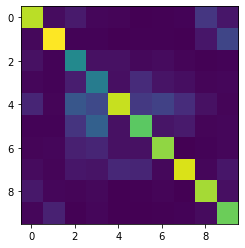

In [0]:
confusion = np.array(confusion)
plt.imshow(confusion)